In [5]:
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

from utils.dataio import *
from utils.visualization import *

plt.rcParams.update({'font.weight': 'semibold', 'font.family': 'DejaVu Serif'})

DATA_DIR = '../data/'
RESULTS_DIR = '../results_new/'

### Load data

In [6]:
config = load_config('../config.yaml')
sample_list = [5,6,7,8,9]
n_samples = len(sample_list)
lr_nf = 5e-3

In [7]:
ip_gt = load_mat(os.path.join(DATA_DIR, 'IP_APACT_1.mat'))
ip_gt = standardize(ip_gt)
data_range_ip = 15.5 # ip_gt.max() - ip_gt.min()
data_range_sos = 150

DAS.

In [8]:
v_das_list = [1510, 1510, 1508, 1505, 1508]
ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(v_das_list))) for _ in range(5)]

for idx, (sample_id, v_das) in enumerate(zip(sample_list, v_das_list)):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    params = f'v_das={v_das:.1f}m·s⁻¹'
    results_path = os.path.join(RESULTS_DIR, tps['task'], 'DAS', params)
    ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'log.json'))
    ip_psnrs[idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
    ip_ssims[idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
    times[idx] = log['time']

In [9]:
print('DAS')
print('IP PSNR:', ip_psnrs.mean().round(2))
print('IP SSIM:', ip_ssims.mean().round(3))
print('Time:', times.mean().round(2))

DAS
IP PSNR: 21.49
IP SSIM: 0.372
Time: 0.13


Dual-SOS DAS.

In [10]:
v_body_list = [1560, 1570, 1547, 1540, 1548]
ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(v_das_list))) for _ in range(5)]

for idx, (sample_id, v_body) in enumerate(zip(sample_list, v_body_list)):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    params = f'v_body={v_body:.1f}m·s⁻¹'
    results_path = os.path.join(RESULTS_DIR, tps['task'], 'Dual-SOS_DAS', params)
    ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'log.json'))
    ip_psnrs[idx] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
    ip_ssims[idx] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
    times[idx] = log['time']

In [11]:
print('Dual-SOS DAS')
print('IP PSNR:', ip_psnrs.mean().round(2))
print('IP SSIM:', ip_ssims.mean().round(3))
print('Time:', times.mean().round(2))

Dual-SOS DAS
IP PSNR: 24.42
IP SSIM: 0.446
Time: 0.12


### Number of delays 

In [12]:
n_delays_list = [64,32,16,8,4,2]
n_delays_list.sort()

APACT.

In [13]:
ip_psnrs_apact, ip_ssims_apact, sos_psnrs_apact, sos_ssims_apact, times_apact = \
    [np.zeros((n_samples, len(n_delays_list))) for _ in range(5)]

for i, sample_id in enumerate(sample_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    for j, n_delays in enumerate(n_delays_list):
        params = f'{n_delays}delays'
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'APACT', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs_apact[i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims_apact[i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs_apact[i, j] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims_apact[i, j] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times_apact[i, j] = log['time']

In [14]:
print('APACT')
print('IP PSNR:', ip_psnrs_apact.mean(0).round(2))
print('IP SSIM:', ip_ssims_apact.mean(0).round(3))
print('SOS PSNR:', sos_psnrs_apact.mean(0).round(2))
print('SOS SSIM:', sos_ssims_apact.mean(0).round(3))
print('Time:', times_apact.mean(0).round(1))

APACT
IP PSNR: [21.24 21.39 21.5  21.49 21.49 21.49]
IP SSIM: [0.107 0.322 0.398 0.434 0.447 0.448]
SOS PSNR: [15.39 18.3  18.18 17.74 17.79 17.84]
SOS SSIM: [0.908 0.912 0.912 0.908 0.907 0.912]
Time: [ 702.5  841.6 1026.  1368.8 2516.2 4531.8]


Pixel Grid.

In [15]:
ip_psnrs_pg, ip_ssims_pg, sos_psnrs_pg, sos_ssims_pg, times_pg = \
    [np.zeros((n_samples, len(n_delays_list))) for _ in range(5)]

for i, sample_id in enumerate(sample_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    for j, n_delays in enumerate(n_delays_list):
        params = f'{n_delays}delays_TV={1e-4:.1e}_{30}epochs_bs={64}_lr={0.1:.1e}'
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'PG', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs_pg[i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims_pg[i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs_pg[i, j] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims_pg[i, j] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times_pg[i, j] = log['time']

In [16]:
print('Ours (PG)')
print('IP PSNR:', ip_psnrs_pg.mean(0).round(2))
print('IP SSIM:', ip_ssims_pg.mean(0).round(3))
print('SOS PSNR:', sos_psnrs_pg.mean(0).round(2))
print('SOS SSIM:', sos_ssims_pg.mean(0).round(3))
print('Time:', times_pg.mean(0).round(1))

Ours (PG)
IP PSNR: [23.51 24.14 25.01 25.05 25.17 25.17]
IP SSIM: [0.219 0.372 0.475 0.514 0.546 0.548]
SOS PSNR: [19.7  19.24 21.42 21.11 21.51 21.48]
SOS SSIM: [0.901 0.912 0.9   0.9   0.901 0.901]
Time: [ 53.1  57.6  75.8 119.6 187.5 335.8]


Pixel grid w/o TV.

In [17]:
# ip_psnrs_pg_wotv, ip_ssims_pg_wotv, sos_psnrs_pg_wotv, sos_ssims_pg_wotv, times_pg_wotv = \
#     [np.zeros((n_samples, len(n_delays_list))) for _ in range(5)]

# for i, sample_id in enumerate(sample_list):
#     tps = config[f'numerical {sample_id}']
#     sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
#     for j, n_delays in enumerate(n_delays_list):
#         params = f'{n_delays}delays_{10}epochs_bs={64}_lr={0.1:.1e}'
#         results_path = os.path.join(RESULTS_DIR, tps['task'], 'PG', params)
#         ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
#         sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
#         ip_rec = standardize(ip_rec)
#         log = load_log(os.path.join(results_path, 'log.json'))
#         ip_psnrs_pg_wotv[i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
#         ip_ssims_pg_wotv[i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
#         sos_psnrs_pg_wotv[i, j] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
#         sos_ssims_pg_wotv[i, j] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
#         times_pg_wotv[i, j] = log['time']

NF-APACT.

In [18]:
ip_psnrs_nf, ip_ssims_nf, sos_psnrs_nf, sos_ssims_nf, times_nf = \
    [np.zeros((n_samples, len(n_delays_list))) for _ in range(5)]

for i, sample_id in enumerate(sample_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    for j, n_delays in enumerate(n_delays_list):
        params = f'{n_delays}delays_{0}lyrs_{128}fts_{10}epochs_bs={64}_lr={lr_nf:.1e}'
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'NF-APACT', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs_nf[i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims_nf[i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs_nf[i, j] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims_nf[i, j] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times_nf[i, j] = log['time']

In [19]:
print('Ours (NF)')
print('IP PSNR:', ip_psnrs_nf.mean(0).round(2))
print('IP SSIM:', ip_ssims_nf.mean(0).round(3))
print('SOS PSNR:', sos_psnrs_nf.mean(0).round(2))
print('SOS SSIM:', sos_ssims_nf.mean(0).round(3))
print('Time:', times_nf.mean(0).round(1))

Ours (NF)
IP PSNR: [23.77 24.37 24.99 25.   25.11 25.11]
IP SSIM: [0.235 0.376 0.477 0.514 0.546 0.548]
SOS PSNR: [20.85 19.29 22.42 22.01 22.23 22.49]
SOS SSIM: [0.935 0.921 0.935 0.937 0.932 0.934]
Time: [ 17.   24.5  26.5  39.7  66.1 118.6]


Multi-channel Deconvolution.

In [20]:
ip_psnrs_deconv, ip_ssims_deconv, times_deconv = [np.zeros((n_samples, len(n_delays_list))) for _ in range(3)]

for i, sample_id in enumerate(sample_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    for j, n_delays in enumerate(n_delays_list):
        params = f'{n_delays}delays_bs={64}'
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'Deconv', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs_deconv[i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims_deconv[i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        times_deconv[i, j] = log['time']

In [21]:
print('MC Deconv')
print('IP PSNR:', ip_psnrs_deconv.mean(0).round(2))
print('IP SSIM:', ip_ssims_deconv.mean(0).round(3))
print('Time:', times_deconv.mean(0).round(1))

MC Deconv
IP PSNR: [23.83 25.02 25.41 25.61 25.74 25.75]
IP SSIM: [0.226 0.359 0.469 0.537 0.579 0.581]
Time: [0.6 0.9 1.5 2.6 5.  9.7]


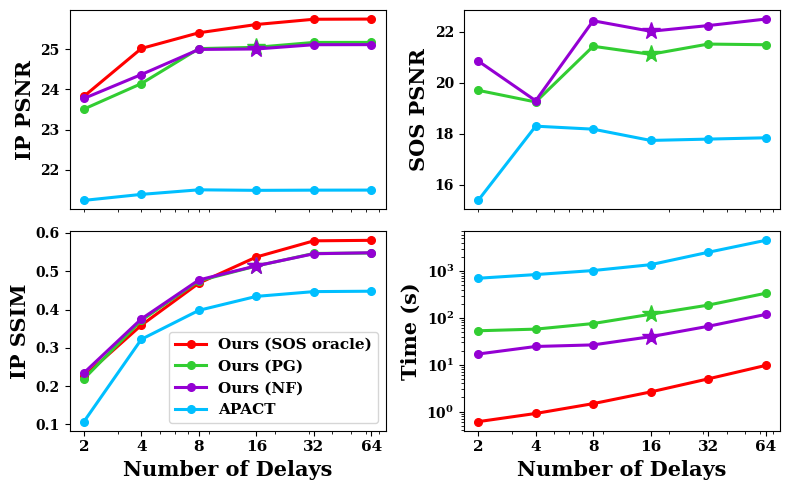

In [22]:
fig = plt.figure(figsize=(8,5))

ax = plt.subplot(2,2,1)
ax.plot(n_delays_list, np.mean(ip_psnrs_deconv, axis=0), label='Ours + SOS oracle', marker='o', markersize=5.5, color='red', linewidth=2.2)
ax.plot(n_delays_list, np.mean(ip_psnrs_apact, axis=0), label='APACT', marker='o', markersize=5.5, color='deepskyblue', linewidth=2.2)
ax.plot(n_delays_list, np.mean(ip_psnrs_pg, axis=0), label='Ours (PG)', marker='o', markersize=5.5, color='limegreen', linewidth=2.2)
ax.plot(n_delays_list[-3], np.mean(ip_psnrs_pg[:,-3], axis=0), marker='*', markersize=13, color='limegreen')
# ax.plot(n_delays_list, np.mean(ip_psnrs_pg_wotv, axis=0), label='PG w/o TV', marker='o', markersize=5.5, color='limegreen', linewidth=2.2, linestyle=':')
ax.plot(n_delays_list, np.mean(ip_psnrs_nf, axis=0), label='Ours (NF)', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(n_delays_list[-3], np.mean(ip_psnrs_nf[:,-3], axis=0), marker='*', markersize=13, color='darkviolet')
ax.set_ylabel('IP PSNR', fontsize=15, fontweight='semibold')
# ax.set_ylim([21, 27])
ax.set_xscale('log')
ax.set_xticks([])

ax = plt.subplot(2,2,3)
ax.plot(n_delays_list, np.mean(ip_ssims_deconv, axis=0), label='Ours (SOS oracle)', marker='o', markersize=5.5, color='red', linewidth=2.2)
ax.plot(n_delays_list, np.mean(ip_ssims_pg, axis=0), label='Ours (PG)', marker='o', markersize=5.5, color='limegreen', linewidth=2.2)
ax.plot(n_delays_list[-3], np.mean(ip_ssims_pg[:,-3], axis=0), marker='*', markersize=13, color='limegreen')
ax.plot(n_delays_list, np.mean(ip_ssims_nf, axis=0), label='Ours (NF)', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(n_delays_list[-3], np.mean(ip_ssims_nf[:,-3], axis=0), marker='*', markersize=13, color='darkviolet')
# ax.plot(n_delays_list, np.mean(ip_ssims_pg_wotv, axis=0), label='PG w/o TV', marker='o', markersize=5.5, color='limegreen', linewidth=2.2, linestyle=':')
ax.plot(n_delays_list, np.mean(ip_ssims_apact, axis=0), label='APACT', marker='o', markersize=5.5, color='deepskyblue', linewidth=2.2)
ax.set_ylabel('IP SSIM', fontsize=15, fontweight='semibold')
# ax.set_ylim([21, 27])
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Number of Delays', fontsize=15, fontweight='semibold')
ax.set_xticks([2,4,8,16,32,64], ['2','4','8','16','32','64'], fontsize=11)
ax.legend(fontsize=11)

ax = plt.subplot(2,2,2)
ax.plot(n_delays_list, np.mean(sos_psnrs_apact, axis=0), label='APACT', marker='o', markersize=5.5, color='deepskyblue', linewidth=2.2)
# ax.errorbar(n_delays_list, np.mean(sos_psnrs_apact, axis=0), yerr=np.std(sos_psnrs_apact, axis=0)/np.sqrt(5), linewidth=2.2, capsize=6, capthick=2, marker='o', markersize=5.5, color='deepskyblue')
ax.plot(n_delays_list, np.mean(sos_psnrs_pg, axis=0), label='Ours (PG)', marker='o', markersize=5.5, color='limegreen', linewidth=2.2)
ax.plot(n_delays_list[-3], np.mean(sos_psnrs_pg[:,-3], axis=0), marker='*', markersize=13, color='limegreen')
# ax.errorbar(n_delays_list, np.mean(sos_psnrs_pg, axis=0), yerr=np.std(sos_psnrs_pg, axis=0)/np.sqrt(5), linewidth=2.2, capsize=6, capthick=2, marker='o', markersize=5.5, color='limegreen')
# ax.plot(n_delays_list, np.mean(sos_psnrs_pg_wotv, axis=0), label='PG w/o TV', marker='o', markersize=5.5, color='limegreen', linewidth=2.2, linestyle=':')
ax.plot(n_delays_list, np.mean(sos_psnrs_nf, axis=0), label='Ours (NF)', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
# ax.errorbar(n_delays_list, np.mean(sos_psnrs_nf, axis=0), yerr=np.std(sos_psnrs_nf, axis=0)/np.sqrt(5), linewidth=2.2, capsize=6, capthick=2, marker='o', markersize=5.5, color='darkviolet')
ax.plot(n_delays_list[-3], np.mean(sos_psnrs_nf[:,-3], axis=0), marker='*', markersize=13, color='darkviolet')
ax.set_ylabel('SOS PSNR', fontsize=15, fontweight='semibold')
# ax.set_ylim([21, 27])
ax.set_xscale('log')
ax.set_xticks([])

# ax = plt.subplot(2,3,5)
# ax.plot(n_delays_list, np.mean(sos_ssims_apact, axis=0), label='APACT', marker='o', markersize=5.5, color='deepskyblue', linewidth=2.2)
# ax.plot(n_delays_list, np.mean(sos_ssims_pg, axis=0), label='Ours (PG)', marker='o', markersize=5.5, color='limegreen', linewidth=2.2)
# ax.plot(n_delays_list[-3], np.mean(sos_ssims_pg[:,-3], axis=0), marker='*', markersize=13, color='limegreen')
# # ax.plot(n_delays_list, np.mean(sos_ssims_pg_wotv, axis=0), label='PG w/o TV', marker='o', markersize=5.5, color='limegreen', linewidth=2.2, linestyle=':')
# ax.plot(n_delays_list, np.mean(sos_ssims_nf, axis=0), label='Ours (NF)', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
# ax.plot(n_delays_list[-3], np.mean(sos_ssims_nf[:,-3], axis=0), marker='*', markersize=13, color='darkviolet')
# ax.set_ylabel('SOS SSIM', fontsize=15, fontweight='semibold')
# # ax.set_ylim([21, 27]) 
# ax.set_xscale('log')
# ax.set_xlabel('Number of Delays', fontsize=15, fontweight='semibold')
# ax.set_xticks([2,4,8,16,32,64], ['2','4','8','16','32','64'], fontsize=11)

ax = plt.subplot(2,2,4)
ax.plot(n_delays_list, np.mean(times_deconv, axis=0), label='Ours + SOS oracle', marker='o', markersize=5.5, color='red', linewidth=2.2)
ax.plot(n_delays_list, np.mean(times_apact, axis=0), label='APACT', marker='o', markersize=5.5, color='deepskyblue', linewidth=2.2)
ax.plot(n_delays_list, np.mean(times_pg, axis=0), label='Ours (PG)', marker='o', markersize=5.5, color='limegreen', linewidth=2.2)
ax.plot(n_delays_list[-3], np.mean(times_pg[:,-3], axis=0), marker='*', markersize=13, color='limegreen')
ax.plot(n_delays_list, np.mean(times_nf, axis=0), label='Ours (NF)', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(n_delays_list[-3], np.mean(times_nf[:,-3], axis=0), marker='*', markersize=13, color='darkviolet')
ax.set_ylabel('Time (s)', fontsize=15, fontweight='semibold')
# ax.set_ylim([21, 27])
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xticks([])
ax.set_xlabel('Number of Delays', fontsize=15, fontname='DejaVu Serif', fontweight='semibold')
ax.set_xticks([2,4,8,16,32,64], ['2','4','8','16','32','64'], fontsize=11, fontname='DejaVu Serif')


# ax = plt.subplot(2,3,6)
# ax.set_ylabel('Memory (GB)', fontsize=15, fontweight='semibold')
# # ax.set_ylim([21, 27])
# ax.set_xscale('log')
# # ax.set_yscale('log')
# ax.set_xlabel('Number of Delays', fontsize=15, fontweight='semibold')
# ax.set_xticks([2,4,8,16,32,64], ['2','4','8','16','32','64'], fontsize=11)

plt.tight_layout()
plt.savefig('figure_ablation_delays.png', bbox_inches='tight', dpi=128)

### TV Regularization weight

In [23]:
lam_tv_list = [1e-6,1e-5,1e-4,1e-3,1e-2]
lam_tv_list.sort()

ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times = [np.zeros((n_samples, len(lam_tv_list))) for _ in range(5)]

for i, sample_id in enumerate(sample_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    for j, lam_tv in enumerate(lam_tv_list):
        if lam_tv == 0:
            params = '{}delays_{}epochs_bs={}_lr={:.1e}'.format(16, 30, 64, 1e-1)
        else:
            params = '{}delays_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(16, lam_tv, 30, 64, 1e-1)
        results_path = os.path.join(RESULTS_DIR, tps['task'], 'PG', params)
        ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'log.json'))
        ip_psnrs[i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
        ip_ssims[i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
        sos_psnrs[i, j] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
        sos_ssims[i, j] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
        times[i, j] = log['time']

In [24]:
print('IP PSNR:', ip_psnrs.mean(0).round(2))
print('IP SSIM:', ip_ssims.mean(0).round(3))
print('SOS PSNR:', sos_psnrs.mean(0).round(2))

IP PSNR: [25.   25.05 25.05 24.8  23.34]
IP SSIM: [0.508 0.515 0.514 0.491 0.37 ]
SOS PSNR: [13.13 18.26 21.11 20.04 13.84]


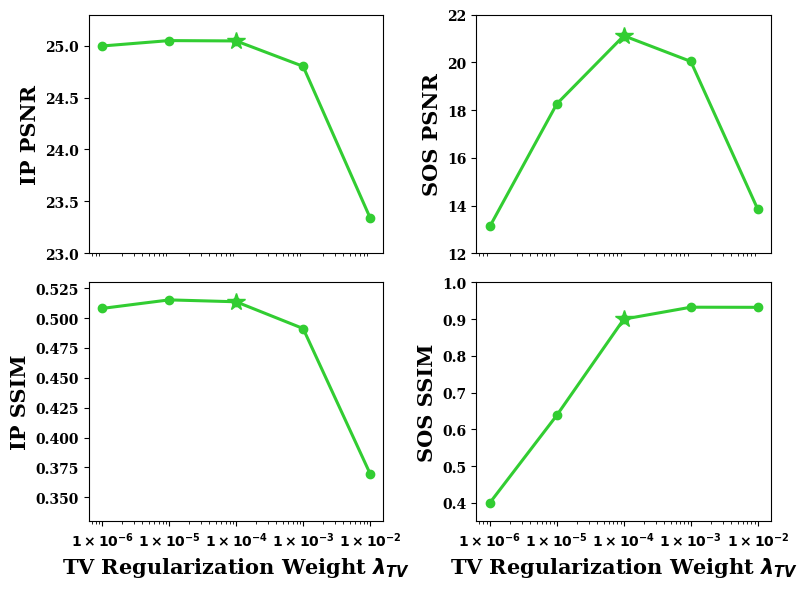

In [25]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(2,2,1)
line_psnr = ax.plot(lam_tv_list, ip_psnrs.mean(0), label='IP PSNR', marker='o', color='limegreen', linewidth=2.2)
ax.plot(lam_tv_list[2], ip_psnrs[:,2].mean(0), marker='*', markersize=13, color='limegreen')
ax.set_ylabel('IP PSNR', fontsize=15, fontweight='semibold')
ax.set_xscale('log')
ax.set_xticks([])
ax.set_ylim([23, 25.3])

ax = plt.subplot(2,2,3)
line_ssim = ax.plot(lam_tv_list, ip_ssims.mean(0), label='IP SSIM', marker='o', color='limegreen', linewidth=2.2)
ax.plot(lam_tv_list[2], ip_ssims[:,2].mean(0), marker='*', markersize=13, color='limegreen')
ax.set_xscale('log')
ax.set_ylabel('IP SSIM', fontsize=15, fontweight='semibold')
ax.set_xticks([])
ax.set_ylim([0.33, 0.53])
ax.set_xticks([1e-6,1e-5,1e-4,1e-3,1e-2], 
              [r'$1\times10^{-6}$', r'$1\times10^{-5}$', r'$1\times10^{-4}$', r'$1\times10^{-3}$', r'$1\times10^{-2}$'],
              fontsize=10, fontweight='semibold')
ax.set_xlabel('TV Regularization Weight $\lambda_{TV}$', fontsize=15, fontweight='semibold')

ax = plt.subplot(2,2,2)
line_psnr = ax.plot(lam_tv_list, sos_psnrs.mean(0), label='SOS PSNR', marker='o', color='limegreen', linewidth=2.2)
ax.plot(lam_tv_list[2], sos_psnrs[:,2].mean(0), marker='*', markersize=13, color='limegreen')
ax.set_xscale('log')
ax.set_xticks([])
ax.set_ylim([12, 22])
ax.set_ylabel('SOS PSNR', fontsize=15, fontweight='semibold')

ax = plt.subplot(2,2,4)
line_psnr = ax.plot(lam_tv_list, sos_ssims.mean(0), label='SOS PSNR', marker='o', color='limegreen', linewidth=2.2)
ax.plot(lam_tv_list[2], sos_ssims[:,2].mean(0), marker='*', markersize=13, color='limegreen')
ax.set_xscale('log')
ax.set_ylim([0.35, 1.0])
ax.set_ylabel('SOS SSIM', fontsize=15, fontweight='semibold')
ax.set_xticks([1e-6,1e-5,1e-4,1e-3,1e-2], 
              [r'$1\times10^{-6}$', r'$1\times10^{-5}$', r'$1\times10^{-4}$', r'$1\times10^{-3}$', r'$1\times10^{-2}$'],
              fontsize=10, fontweight='semibold')
ax.set_xlabel('TV Regularization Weight $\lambda_{TV}$', fontsize=15, fontweight='semibold')

plt.tight_layout()
plt.savefig('figure_ablation_lam_tv.png', bbox_inches='tight', dpi=128)

In [26]:
# fig = plt.figure(figsize=(8,5))
# ax1 = plt.subplot(2,2,1)
# ax2 = ax1.twinx()
# line_psnr = ax1.plot(lam_tv_list, ip_psnrs.mean(0), label='IP PSNR', marker='o', color='deepskyblue', linewidth=2.2)
# line_ssim = ax2.plot(lam_tv_list, ip_ssims.mean(0), label='IP SSIM', marker='^', color='red', linewidth=2.2)
# ax1.set_ylabel('PSNR', fontsize=15, fontweight='semibold')
# ax2.set_ylabel('SSIM', fontsize=15, fontweight='semibold')
# # ax1.set_ylim([18.2, 18.6])
# # ax2.set_ylim([0.439, 0.450])
# ax1.set_xscale('log')
# ax1.set_xticks([])
# lns = line_psnr + line_ssim
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, fontsize=15, loc='lower center')

# ax1 = plt.subplot(2,2,2)
# ax2 = ax1.twinx()
# line_psnr = ax1.plot(lam_tv_list, sos_psnrs.mean(0), label='SOS PSNR', marker='o', color='deepskyblue', linewidth=2.2)
# line_ssim = ax2.plot(lam_tv_list, sos_ssims.mean(0), label='SOS SSIM', marker='^', color='red', linewidth=2.2)
# # ax.set_ylim([16.5, 17.7])
# ax1.set_xscale('log')
# ax1.set_ylabel('PSNR', fontsize=15, fontweight='semibold')
# ax2.set_ylabel('SSIM', fontsize=15, fontweight='semibold')
# ax1.set_xticks([1e-6,1e-5,1e-4,1e-3,1e-2], 
#               [r'$1\times10^{-6}$', r'$1\times10^{-5}$', r'$1\times10^{-4}$', r'$1\times10^{-3}$', r'$1\times10^{-2}$'],
#               fontsize=10, fontweight='semibold')
# ax1.set_xlabel('TV Regularization Weight $\lambda_{TV}$', fontsize=15, fontweight='semibold')
# lns = line_psnr + line_ssim
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, fontsize=15, loc='lower center')

# plt.tight_layout()
# # plt.savefig('figure_ablation_lam_tv.png', bbox_inches='tight', dpi=128)

### Network structure

In [27]:
hidden_fts_list = [32,64,128,256, 512]
hidden_fts_list.sort()
hidden_lyrs_list = [0,1]
hidden_lyrs_list.sort()

ip_psnrs, ip_ssims, sos_psnrs, sos_ssims, times, n_params = [np.zeros((n_samples, len(hidden_lyrs_list), len(hidden_fts_list))) for _ in range(6)]

for k, sample_id in enumerate(sample_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    for i, hidden_lyrs in enumerate(hidden_lyrs_list):
        for j, hidden_fts in enumerate(hidden_fts_list):
            params = '{}delays_{}lyrs_{}fts_{}epochs_bs={}_lr={:.1e}'.format(16, hidden_lyrs, hidden_fts, 10, 64, lr_nf)
            results_path = os.path.join(RESULTS_DIR, tps['task'], 'NF-APACT', params)
            ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
            sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
            ip_rec = standardize(ip_rec)
            log = load_log(os.path.join(results_path, 'log.json'))
            ip_psnrs[k, i, j] = psnr(ip_gt, ip_rec, data_range=data_range_ip)
            ip_ssims[k, i, j] = ssim(ip_gt, ip_rec, data_range=data_range_ip)
            sos_psnrs[k, i, j] = psnr(sos_gt, sos_rec, data_range=data_range_sos)
            sos_ssims[k, i, j] = ssim(sos_gt, sos_rec, data_range=data_range_sos)
            times[k, i, j] = log['time']
            n_params[k, i, j] = log['n_params']

In [28]:
print('IP PSNR (0HL):', ip_psnrs[:,0,:].mean(0).round(2))
print('IP PSNR (1HL):', ip_psnrs[:,1,:].mean(0).round(2))
print('IP SSIM (0HL):', ip_ssims[:,0,:].mean(0).round(3))
print('IP SSIM (1HL):', ip_ssims[:,1,:].mean(0).round(3))
print('SOS PSNR (0HL):', sos_psnrs[:,0,:].mean(0).round(2))
print('SOS PSNR (1HL):', sos_psnrs[:,1,:].mean(0).round(2))
print('SOS SSIM (0HL):', sos_ssims[:,0,:].mean(0).round(3))
print('SOS SSIM (1HL):', sos_ssims[:,1,:].mean(0).round(3))
print('Time (0HL):', times[:,0,:].mean(0).round(2))
print('Time (1HL):', times[:,1,:].mean(0).round(2))
print('Params (0HL):', n_params[0,0,:].astype(int))
print('Params (1HL):', n_params[0,1,:].astype(int))

IP PSNR (0HL): [25.07 25.   25.   25.14 25.1 ]
IP PSNR (1HL): [25.09 25.02 24.92 24.74 24.49]
IP SSIM (0HL): [0.514 0.514 0.514 0.521 0.519]
IP SSIM (1HL): [0.518 0.515 0.499 0.487 0.469]
SOS PSNR (0HL): [21.38 22.34 22.01 22.46 22.12]
SOS PSNR (1HL): [21.07 20.78 15.88 13.98 14.18]
SOS SSIM (0HL): [0.942 0.94  0.937 0.933 0.929]
SOS SSIM (1HL): [0.845 0.757 0.447 0.413 0.405]
Time (0HL): [39.71 39.74 39.75 41.66 41.14]
Time (1HL): [39.72 40.01 40.08 42.52 46.25]
Params (0HL): [ 131  259  515 1027 2051]
Params (1HL): [  1187   4419  17027  66819 264707]


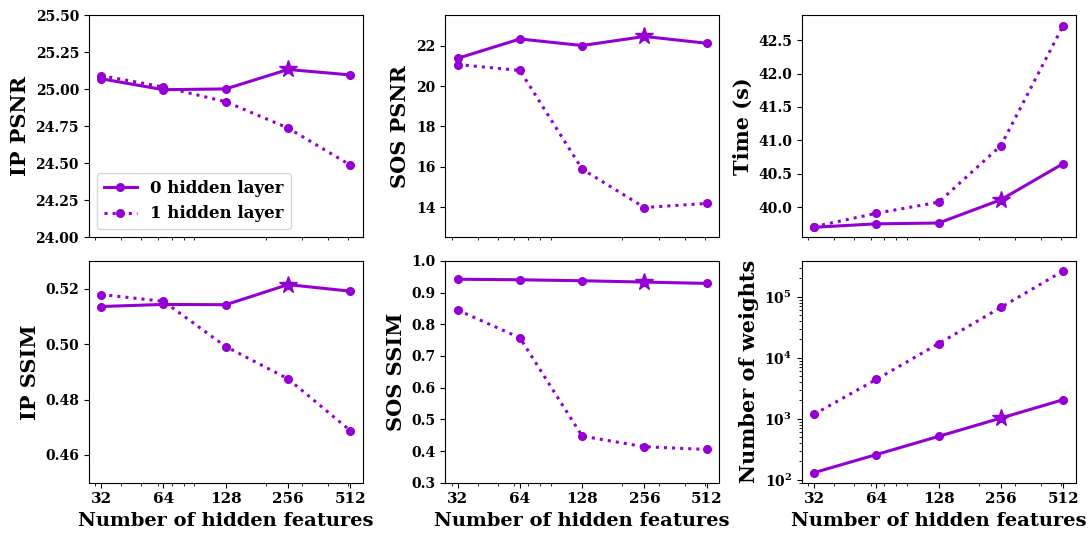

In [32]:
fig = plt.figure(figsize=(11,5.5))
ax = plt.subplot(2,3,1)
ax.plot(hidden_fts_list, ip_psnrs[:,0,:].mean(0), label='0 hidden layer', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list, ip_psnrs[:,1,:].mean(0), label='1 hidden layer', linestyle=':', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list[-2], ip_psnrs[:,0,-2].mean(0), marker='*', markersize=13, color='darkviolet')
ax.set_ylabel('IP PSNR', fontsize=15, fontweight='semibold')
ax.set_ylim([24, 25.5])
ax.set_xscale('log')
ax.set_xticks([])
ax.legend(fontsize=12, loc='lower left')

ax = plt.subplot(2,3,4)
ax.plot(hidden_fts_list, ip_ssims[:,0,:].mean(0), label='0 hidden layer', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list, ip_ssims[:,1,:].mean(0), label='1 hidden layer', linestyle=':', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list[-2], ip_ssims[:,0,-2].mean(0), marker='*', markersize=13, color='darkviolet')
ax.set_xlabel('Number of hidden features', fontsize=14, fontweight='semibold')
ax.set_ylabel('IP SSIM', fontsize=15, fontweight='semibold')
ax.set_ylim([0.45, 0.53])
ax.set_xscale('log')
ax.set_xticks([])
ax.set_xticks([32,64,128,256,512], ['32','64','128','256','512'], fontsize=11)

ax = plt.subplot(2,3,2)
ax.plot(hidden_fts_list, sos_psnrs[:,0,:].mean(0), label='0 hidden layer', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list, sos_psnrs[:,1,:].mean(0), label='1 hidden layer', linestyle=':', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list[-2], sos_psnrs[:,0,-2].mean(0), marker='*', markersize=13, color='darkviolet')
ax.set_ylabel('SOS PSNR', fontsize=15, fontweight='semibold')
ax.set_ylim([12.5, 23.5])
ax.set_xscale('log')
ax.set_xticks([])
# ax.legend(fontsize=12, loc='lower left')

ax = plt.subplot(2,3,5)
ax.plot(hidden_fts_list, sos_ssims[:,0,:].mean(0), label='0 hidden layer', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list, sos_ssims[:,1,:].mean(0), label='1 hidden layer', linestyle=':', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list[-2], sos_ssims[:,0,-2].mean(0), marker='*', markersize=13, color='darkviolet')
ax.set_xlabel('Number of hidden features', fontsize=14, fontweight='semibold')
ax.set_ylabel('SOS SSIM', fontsize=15, fontweight='semibold')
ax.set_ylim([0.3,1.0])
ax.set_xscale('log')
ax.set_xticks([])
ax.set_xticks([32,64,128,256, 512], ['32','64','128','256','512'], fontsize=11)

ax = plt.subplot(2,3,3)
ax.plot(hidden_fts_list, np.median(times[:,0,:],axis=0), label='0 hidden layer', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list, np.median(times[:,1,:],axis=0), label='1 hidden layer', linestyle=':', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list[-2], np.median(times[:,0,-2],axis=0), marker='*', markersize=13, color='darkviolet')
ax.set_ylabel('Time (s)', fontsize=15, fontweight='semibold')
# ax.set_ylim([24.0, 25.7])
ax.set_xscale('log')
ax.set_xticks([])
# ax.legend(fontsize=12, loc='lower left')

ax = plt.subplot(2,3,6)
ax.plot(hidden_fts_list, n_params[:,0,:].mean(0), label='0 hidden layer', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list, n_params[:,1,:].mean(0), label='1 hidden layer', linestyle=':', marker='o', markersize=5.5, color='darkviolet', linewidth=2.2)
ax.plot(hidden_fts_list[-2], n_params[:,0,-2].mean(0), marker='*', markersize=13, color='darkviolet')
ax.set_xlabel('Number of hidden features', fontsize=14, fontweight='semibold')
ax.set_ylabel('Number of weights', fontsize=15, fontweight='semibold')
# ax.set_ylim([24.0, 25.7])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([])
ax.set_xticks([32,64,128,256,512], ['32','64','128','256','512'], fontsize=11)

plt.tight_layout()
plt.savefig('figure_ablation_network.png', bbox_inches='tight', dpi=128)